## Plotting the posterior distribution and the evolution of the integrated autocorrelation times

1. Pick one HDF5 file which contains the MCMC sampling results.
2. Set the burn-in iteration number (`burn_in`). Only the samples after this iteration number are used for plotting.
3. Set the input E(B-V) value (`EBV_mock`).
4. Run the script.

### (iter, nwalkers, ndim) = (6000, 32, 4)
### Save... mock_results/mock_SNR010_metal08_mderrY_EBVpriorF_ONpriorIa1_BurnIn1000.plot_corner.png


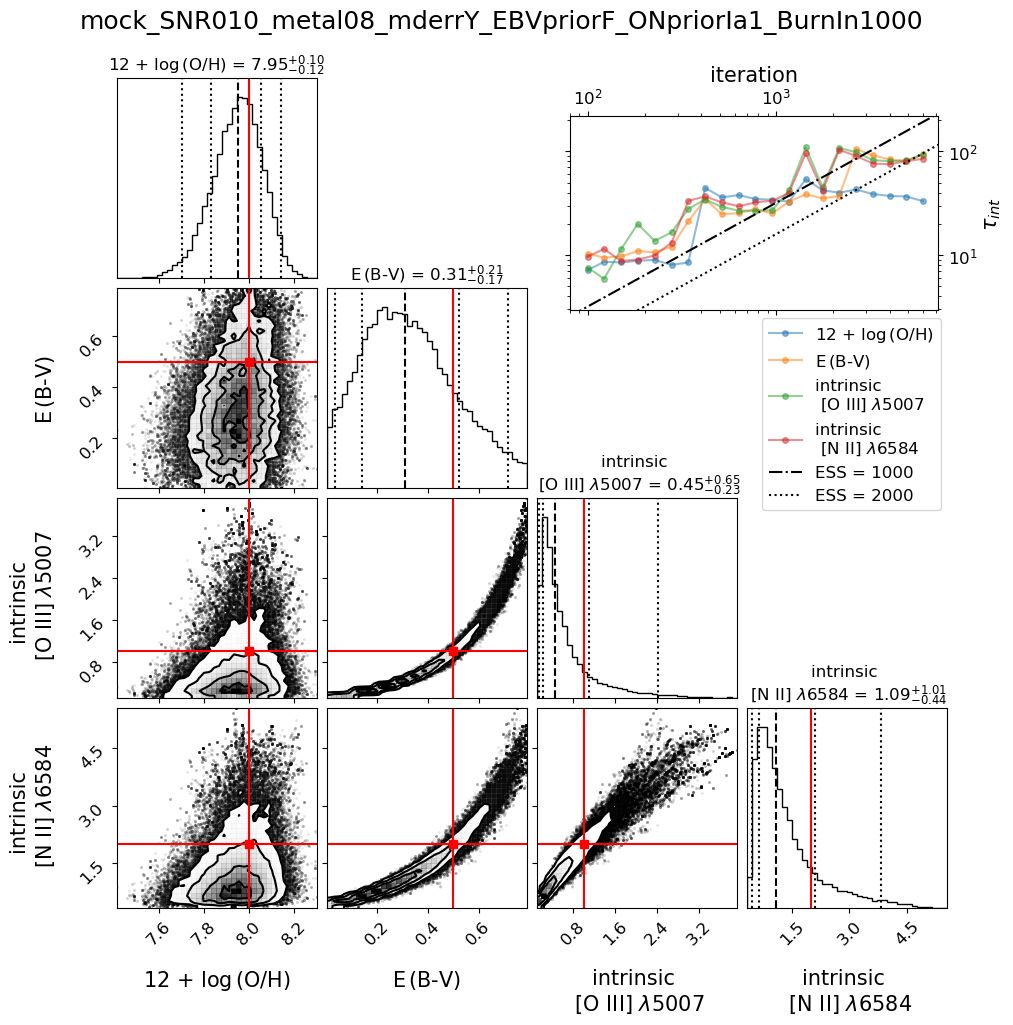

In [11]:
import matplotlib
from os.path import basename, dirname

from corner import corner
from emcee.autocorr import integrated_time
from emcee.backends import HDFBackend
from matplotlib import rc
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.transforms import Bbox
from numpy import concatenate, empty, exp, linspace, log, mean, ndarray, where


def plot_corner(backend_file, burn_in, truths=None, pdf=False, chain_end=None, quantiles=None,
                plotrange=[1, 1, 1, 1]):
    # -- extract chains from backend
    reader = HDFBackend(backend_file)
    dir = dirname(backend_file)
    chain: ndarray = reader.get_chain()
    if chain_end:
        chain = chain[burn_in:burn_in + chain_end, :, :]
    else:
        chain = chain[burn_in:, :, :]
    iteration, nwalkers, ndim = chain.shape
    print('### (iter, nwalkers, ndim) = {}'.format(chain.shape))

    # -- integrated autocorrelation time calculation
    chk_num = 21
    chain_mean = mean(chain, axis=1)
    iat_arr = empty((chk_num, ndim))
    chks = exp(linspace(log(100), log(iteration), chk_num)).astype(int)
    for chk in chks:
        chk_ind = where(chks == chk)[0]
        for dim in range(ndim):
            iat_arr[chk_ind, dim] = integrated_time(chain_mean[:chk, dim], tol=0)
    # -- corner plots
    labels = ['12 + log$\,$(O/H)', 'E$\,$(B-V)', 'intrinsic \n [O III] $\lambda$5007',
              'intrinsic \n [N II] $\lambda$6584', 'ln(posterior)']
    burnin_tag = '_BurnIn{:04d}'.format(burn_in)
    outfile1 = backend_file.replace('.h5', burnin_tag + '.plot_corner.png')
    if pdf: outfile1 = outfile1.replace('.png', '.pdf')
    chain_rsh = chain.reshape([-1, ndim])
    title = basename(backend_file.replace('.h5', burnin_tag))
    ftsize = 15
    rc('axes', labelsize=ftsize)
    rc('xtick', labelsize=ftsize * 0.8)
    rc('ytick', labelsize=ftsize * 0.8)
    if not quantiles: quantiles = [0.025, 0.16, 0.5, 0.84, 0.975]
    fig: Figure = corner(chain_rsh, bins=40, truth_color='red', truths=truths, labels=labels[0:4],
                         quantiles=quantiles, show_titles=True, title_kwargs={'size':ftsize*0.8}, range=plotrange)
    fig.suptitle(title, fontsize=ftsize * 1.2, y=1.03)

    ax0: Axes = fig.add_subplot(111)
    for par in range(ndim): ax0.plot(chks, iat_arr[:, par], '-o', markersize=4, label=labels[par], alpha=0.5)
    chks_ext = concatenate([[chks[0] / 2.], chks])
    chks_ext = concatenate([chks_ext, [chks[-1] * 2.]])
    ess_chk = 1000. / nwalkers
    ax0.plot(chks_ext, chks_ext / ess_chk, '-.k', label='ESS = 1000')
    ess_chk = 2000. / nwalkers
    ax0.plot(chks_ext, chks_ext / ess_chk, ':k', label='ESS = 2000')
    ax0.semilogx()
    ax0.semilogy()
    ax0.tick_params(which='both', top=True, right=True,
                    labelbottom=False, labelleft=False, labeltop=True, labelright=True)
    ax0.xaxis.set_label_position('top')
    ax0.yaxis.set_label_position('right')
    ax0.set_xlim(chks[0] * 0.8, chks[-1] * 1.2)
    ax0.set_ylim(iat_arr.min() * 0.5, iat_arr.max() * 2)
    ax0.set_xlabel('iteration')
    ax0.set_ylabel(r'$\tau_{int}$')
    ax0.legend(fontsize=ftsize * 0.8, loc='upper right', bbox_to_anchor=(1.03, 0))
    if 'line3' in backend_file:
        pos2 = [0.56, 0.72, 0.38, 0.20]
    else:
        pos2 = [0.57, 0.72, 0.38, 0.20]
    ax0.set_position(pos2)
    ## -- save test-run
    print('### Save... ' + outfile1)
    f_enlarge = 1.05
    shift = -0.1
    bb = fig.bbox_inches.bounds
    bb_new = (bb[0] + shift, bb[1] + shift, bb[2] * f_enlarge, bb[3] * f_enlarge)
    fig.savefig(outfile1, bbox_inches=Bbox.from_bounds(*bb_new))

matplotlib.style.use('default')
dir = 'mock_results/'
backend_file = dir+'mock_SNR010_metal08_mderrY_EBVpriorF_ONpriorIa1.h5'
burn_in = 1000
EBV_mock=0.5
mock_input = [8., EBV_mock, 1., 2.]
plot_corner(backend_file, burn_in, truths=mock_input)